In [1]:
import numpy as np
import igl
import meshplot as mp
from scipy.spatial.transform import Rotation
import ipywidgets as iw
import time
import scipy.sparse as sp
import triangle as tr
import matplotlib.pyplot as plt

In [2]:
v, f = igl.read_triangle_mesh('data/woody-hi.off')
cage = np.load('data/woody-hi.cage-1.npy')
skeleton = np.load('data/woody-hi.skeleton.npy')
v -= v.min(axis=0)
v /= v.max()

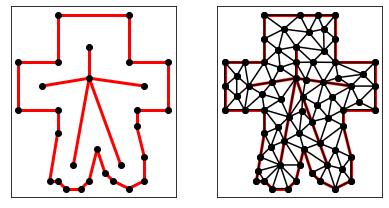

In [3]:
cage_connect = (np.vstack((np.arange(cage.shape[0]), np.arange(cage.shape[0])+1))).T
cage_connect[-1,-1] = 0

num_pure_cage = cage.shape[0]

skeleton_connect = np.array([[0,1],[1,2],[1,3],[1,4],[1,5]])
skeleton_connect += cage.shape[0]

cage = np.vstack((cage, skeleton))
cage_connect = np.vstack((cage_connect, skeleton_connect))

cage_dict = dict(vertices=cage[:,:2], segments=cage_connect, segment_markers=np.ones(cage.shape[0]))
cage_tri = tr.triangulate(cage_dict, 'pqa0.01')

tr.compare(plt, cage_dict, cage_tri)
plt.show()

cage_v = cage_tri['vertices']
cage_f = cage_tri['triangles']
cage_markers = cage_tri['vertex_markers']

cage_v = np.hstack((cage_v, np.zeros((cage_v.shape[0],1))))

In [4]:
num_cage_boundary_v = cage.shape[0]

In [5]:
augmented_boundary = igl.boundary_loop(cage_f)

In [70]:
def is_on_seg(v, a, b):
    av, ab = v-a, b-a
    cosine = np.dot(av, ab)
    cosine = cosine / (np.linalg.norm(av) * np.linalg.norm(ab))
    if np.isclose(cosine,1) and np.linalg.norm(av)/np.linalg.norm(ab) <=1:
        return True
    return False

In [71]:
def tri_boundary_condition(curr_v, segments, vertices):
    for a_ind, b_ind in segments:
        a, b = vertices[a_ind], vertices[b_ind]
        if is_on_seg(vertices[curr_v], a, b):
            len_a = np.linalg.norm(vertices[curr_v] - a)
            len_b = np.linalg.norm(vertices[curr_v] - b)
            len_seg = np.linalg.norm(a - b)
            return a_ind, b_ind, len_b/len_seg, len_a/len_seg

In [72]:
Lw = igl.cotmatrix(cage_v, cage_f)
M = igl.massmatrix(cage_v, cage_f, igl.MASSMATRIX_TYPE_VORONOI)
Minv = sp.diags(1 / M.diagonal())

In [73]:
A = Minv * Lw
Aff = A[np.argwhere(cage_markers!=1)[:,0],:]
Aff = Aff[:,np.argwhere(cage_markers!=1)[:,0]]
Afc = A[np.argwhere(cage_markers!=1)[:,0],:]
Afc = Afc[:,np.argwhere(cage_markers==1)[:,0]]
xc = np.zeros((np.sum(cage_markers), num_cage_boundary_v))
xc[:num_cage_boundary_v,:] = np.eye(num_cage_boundary_v)

augmented_boundary_v = np.argwhere(cage_markers==1)[num_cage_boundary_v:,0]
for i in range(augmented_boundary_v.size):
    curr_v = augmented_boundary_v[i]
    
    a_ind, b_ind, xa, xb = tri_boundary_condition(curr_v, cage_connect, cage_v)
    
    xc[i+num_cage_boundary_v,a_ind] = xa
    xc[i+num_cage_boundary_v,b_ind] = xb

rhs = -Afc * xc
xf = sp.linalg.spsolve(Aff, rhs)
x = np.zeros((cage_v.shape[0], num_cage_boundary_v))
x[:num_cage_boundary_v,:] = xc[:num_cage_boundary_v,:]
x[augmented_boundary_v,:] = xc[num_cage_boundary_v:,:]
x[np.argwhere(cage_markers!=1)[:,0],:] = xf

In [74]:
np.argwhere(cage_markers == 1)[:,0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34,
       35, 36, 41, 42, 43, 44, 46, 48, 53, 54, 57, 64, 65, 66, 69])

In [75]:
augmented_boundary_v

array([29, 30, 31, 33, 34, 35, 36, 41, 42, 43, 44, 46, 48, 53, 54, 57, 64,
       65, 66, 69])

In [76]:
def within_triangle(p, v, f):
    for i in range(f.shape[0]):
        v0 = v[f[i,0]]
        v1 = v[f[i,1]]
        v2 = v[f[i,2]]
        A = np.vstack((v1-v0, v2-v0)).T
        b = (p-v0)
        sol = np.linalg.lstsq(A, b, rcond=None)[0]
        if (sol[0] >= 0 and sol[1] >= 0 and sol[0]+sol[1]<=1):
            return i

In [77]:
def barycentric_coord(p, v, f, i):
    v0 = v[f[i,0]]
    v1 = v[f[i,1]]
    v2 = v[f[i,2]]
    A = np.vstack((v0,v1,v2)).T
    A = np.vstack((A, np.ones((1,3))))
    b = np.hstack((p, np.array([1,])))
    w = np.linalg.lstsq(A, b, rcond=None)[0]
    return w

In [78]:
hc = np.zeros((v.shape[0], num_cage_boundary_v))
for i in range(v.shape[0]):
    cage_tri_ind = within_triangle(v[i], cage_v, cage_f)
    w = barycentric_coord(v[i], cage_v, cage_f, cage_tri_ind)
    hc[i,:] = w[0]*x[cage_f[cage_tri_ind,0], :] \
            + w[1]*x[cage_f[cage_tri_ind,1], :] \
            + w[2]*x[cage_f[cage_tri_ind,2], :]

In [79]:
cage_v_copy = cage_v.copy()
v_copy = v.copy()
def pos_f(selected_vertices, x,y,z):
    t0 = time.time()
    
    if len(selected_vertices) > 0:
        cage_v_copy[selected_vertices,:] = cage_v[selected_vertices,:] + np.array([x,y,z])
    v_deformed = pos_f.deformer(cage_v_copy)
    global point_oid
    global line_oid
    p.remove_object(point_oid)
    p.remove_object(line_oid)
    point_color = np.zeros(num_cage_boundary_v)
    if len(selected_vertices) > 0:
        point_color[np.array(selected_vertices)] = 1
    point_oid = p.add_points(cage_v_copy[:num_cage_boundary_v,:], c=point_color, shading={"point_size":0.1})
    line_oid = p.add_lines((cage_v_copy[cage_connect[:,0]])[:num_cage_boundary_v,:], (cage_v_copy[cage_connect[:,1]])[:num_cage_boundary_v,:])
    
    p.update_object(oid=0, vertices = v_deformed)
    
    t1 = time.time()
    print('FPS', 1/(t1 - t0))

In [80]:
def widgets_wrapper():
    select_widget = iw.SelectMultiple(
                            options=np.arange(num_cage_boundary_v),
                            rows=10,
                            description="Select Cage Vertices")
    translate_widget = {i:iw.FloatSlider(min=-1, max=1, value=0) 
                        for i in 'xyz'}

    widgets_dict = dict(selected_vertices=select_widget)
    widgets_dict.update(translate_widget)
    return widgets_dict

In [81]:
def position_deformer(cage_v_copy):
    
    return hc @ cage_v_copy[:num_cage_boundary_v,:]

# Register this function to perform interactive deformation
pos_f.deformer = position_deformer

In [82]:
p = mp.plot(v, f)
point_oid = p.add_points(cage, shading={"point_size":0.1})
line_oid = p.add_lines(cage[cage_connect[:,0]], cage[cage_connect[:,1]])

iw.interact(pos_f,
            **widgets_wrapper())

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4306930…

interactive(children=(SelectMultiple(description='Select Cage Vertices', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9…

<function __main__.pos_f(selected_vertices, x, y, z)>

In [19]:
p.update_object(oid=0, colors=hc[:,20])